<p style="color:#e8574d; font-size:30px; font-weight:bold; font-family:Helvetica"> Content </p>

<ul style="font-size:16px; font-family:Helvetica">
    <li><a href='#copyright' style="color:#696969; text-decoration: none">Copyright and License</a></li>
    <li><a href='#modules' style="color:#696969; text-decoration: none">All Necessary Modules and Datasets</a></li>
    <li><a href='#eda' style="color:#696969; text-decoration: none">Exploratory Data Analysis</a></li>
    <li><a href='#timer' style="color:#696969; text-decoration: none">Time Complexity: Big Bird and Transformers</a></li>
    <li><a href='#cited' style="color:#696969; text-decoration: none">Reference</a></li>
</ul> 



<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Copyright and License<a id='copyright'></a></p>

<p style="color:#696969; font-size:14px">License and copyright notice</p>

In [1]:
!pip show bigbird

Name: bigbird
Version: 0.0.1
Summary: Big Bird: Transformers for Long Sequences
Home-page: http://github.com/google-research/bigbird
Author: Google Inc.
Author-email: no-reply@google.com
License: Apache 2.0
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: absl-py, numpy, rouge-score, sentencepiece, tensor2tensor, tensorflow, tfds-nightly, tensorflow-text, natsort
Required-by: 


<p style="color:#696969; font-size:14px; margin:0px; padding:0px">State changes:</p>
<p style='font-family:monospace; margin-left:20px'>Name:</p>

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">All Necessary Modules and Datasets<a id='module'></a></p>

In [2]:
# Transformers and BigBird
from transformers import BigBirdTokenizer, BigBirdModel
import transformers

# PyTorch manipulation
from torchvision.transforms import ToTensor
import torch

# Reading and manipulate NLP data
import pandas as pd
from random import sample
import numpy as np
import re
from nltk.corpus import words
import math

# Plot
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
# Clean text up
def clean_up_text(thedict):
    for i in range(len(thedict['abstract_text'])):
        # Remove all <S> and </S> and double spaces and ", " in abstract text
        thedict['abstract_text'][i] = thedict['abstract_text'][i].replace('<S>','').replace(
        '</S>','').replace('", "','')
        thedict['abstract_text'][i] = re.sub(' +', ' ',thedict['abstract_text'][i])
        # Remove all @\w+, ", ", and \\\\ in article text
        thedict['article_text'][i] = re.sub('@\w+','', thedict['article_text'][i])
        thedict['article_text'][i] = thedict['article_text'][i].replace('", "','')
        thedict['article_text'][i] = re.sub('@\w+','',thedict['article_text'][i].replace(
        '", "','').replace('["',''))
        thedict['article_text'][i] = re.sub('\\\\','',thedict['article_text'][i])
    return thedict

# Create reading arxiv data for this particular txt problem
def read_arxiv_data(directory):
    with open(directory) as f: # read lines
        lines = f.readlines()
    article_id = []            # Instantiate empty lists
    article_text = []
    abstract_text = []
    for i in range(len(lines)): # for loop to find start and end strings
        article_id.append(lines[i][lines[i].find('"article_id": "')+len(
        '"article_id": "'):lines[i].find('",')])
        article_text.append(lines[i][lines[i].find('"article_text": ')+len(
        '"article_text": '):lines[i].find('"], ')])
        abstract_text.append(lines[i][lines[i].find('"abstract_text": ["<S>')+len(
            'abstract_text": ["<S>  '):lines[i].find(' </S>"]')])
    thedict = {'article_id':article_id,'article_text':article_text,'abstract_text':abstract_text} 
    return clean_up_text(thedict) # Use clean up tool 

In [4]:
# Read validation set
result = read_arxiv_data('arxiv-dataset/val.txt')

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Exploratory Data Analysis<a id='eda'></a></p>

In [5]:
np.random.seed(121)
r = int(np.random.choice(range(len(result['article_id'])), size=1))

In [6]:
print(result['article_id'][r])

1011.3627


In [7]:
print(result['abstract_text'][r])

we report results of fully non - perturbative calculations , based on auxiliary field quantum monte carlo ( afqmc ) approach , for the dilute neutron matter at the density @xmath0 . fundamental quantities which characterize the superfluid state : the single particle energy gap @xmath1 , and the critical temperature @xmath2 have been determined . the large value of @xmath3 indicates that the system is not a bcs - type superfluid at low temperatures .


In [8]:
print(result['article_text'][r])

although a homogeneous neutron matter is one of the simplest nuclear systems , its importance can not be overemphasized since it constitutes the main component of neutron stars .the density of the neutron matter forming neutron stars ranges from subnuclear densities ( in the inner crust ) up to extremely high values of  ( expected in the center of the star ) , where  is the saturation density .    in the regime of sufficiently low densitiesone can perform very precise calculations since the neutron - neutron interaction is completely dominated by the scattering in  channel , which is determined by two parameters only : the scattering length  and the effective range  .indeed , at the densities  (  ) the influence of other channels as well as of three - body forces is marginal and can be neglected .the values of the scattering length and the effective range are well known from the low energy scattering experiments and read :  ,  . at the densities where  the dilute neutron matter is an e

In [9]:
# Create the Standard Scaler for dictionary
def z_score(thedict):
    if type(thedict) == type({}): # If dict type
        adict = thedict.copy()
        thedict = list(thedict.values())
    else:
        adict = None
    u = np.mean(thedict)
    s = np.std(thedict)
    x = thedict
    Z = (x - u)/s
    if type(adict) == type({}): # If dict type
        # Instantiate i
        i = 0
        for k in adict.keys():
            adict[k] = Z[i]
            i+=1 
        return adict
    else:             # If not dict type
        return Z

In [10]:
# Check for abstract text sampling convergence
convergence = {}
for i in range(10,3000):
    sampling = sample(result['abstract_text'],i)
    convergence[i] = sum(map(len, sampling))/float(len(sampling))
convergence = z_score(convergence)
# Check for article text sampling convergence
convergence1 = {}
for i in range(10,3000):
    sampling = sample(result['article_text'],i)
    convergence1[i] = sum(map(len, sampling))/float(len(sampling))
convergence1 = z_score(convergence1)

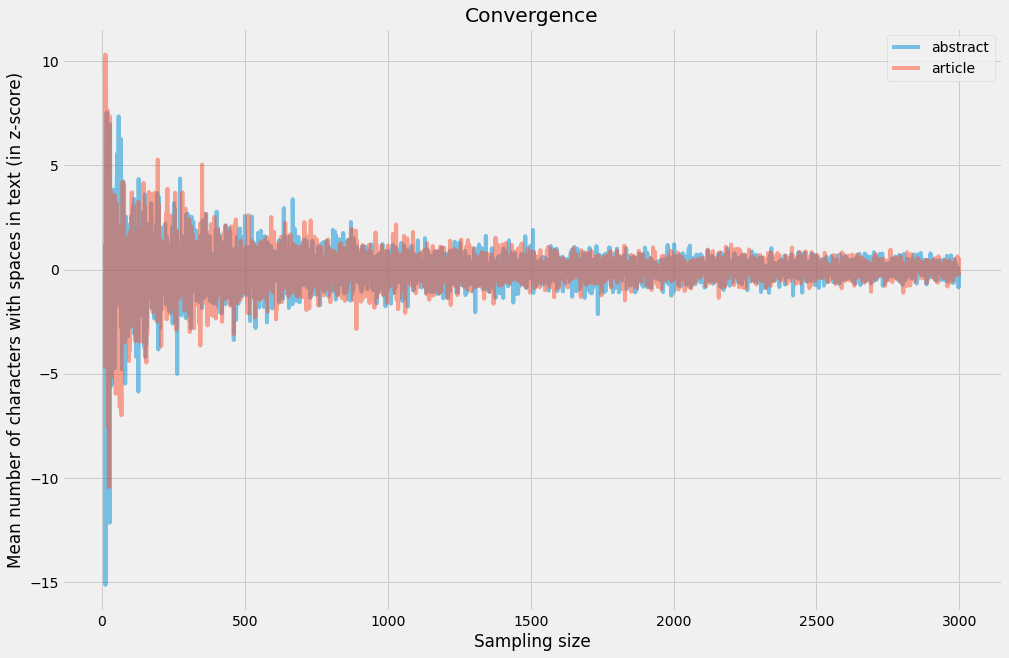

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,10))
plt.plot(convergence.keys(),convergence.values(),alpha=0.5,label = 'abstract')
plt.plot(convergence1.keys(),convergence1.values(),alpha=0.5, label = 'article')
plt.xlabel('Sampling size')
plt.ylabel('Mean number of characters with spaces in text (in z-score)')
plt.title('Convergence')
plt.legend()
plt.show()

In [12]:
# Select 1500 sampling size
sampling = sample(result['abstract_text'],1500)
sampling1 = sample(result['article_text'],1500)

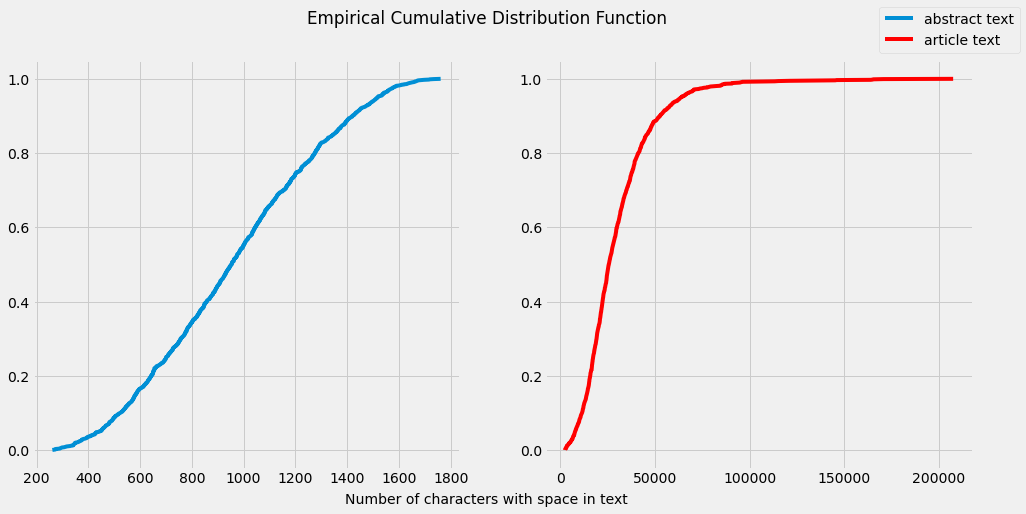

In [13]:
ecdf = ECDF(list(map(len,sampling)))
ecdf1 = ECDF(list(map(len,sampling1)))

# plot the ecdf
fig, ax = plt.subplots(1,2,figsize = (15,7))
ax[0].plot(ecdf.x, ecdf.y, label = 'abstract text')
ax[1].plot(ecdf1.x, ecdf1.y, color = 'red', label = 'article text')
fig.suptitle('Empirical Cumulative Distribution Function')
fig.text(0.5, 0.00, 'Number of characters with space in text', ha='center')
fig.legend()
plt.show()

In [14]:
def str_info(thelist):
    print('length of text')
    print('mean:', round(sum(map(len,thelist))/len(thelist),2))
    print('median:', round(np.median(list(map(len,thelist))),2))
    print('stdev:', round(np.std(list(map(len,thelist))),2))
    print('0.975:', round(np.quantile(list(map(len,thelist)),0.975),2))
    print('0.025:', round(np.quantile(list(map(len,thelist)),0.025),2))

In [15]:
str_info(sampling)

length of text
mean: 960.48
median: 953.0
stdev: 331.28
0.975: 1574.52
0.025: 371.48


In [16]:
str_info(sample(result['article_text'],1500))

length of text
mean: 30064.7
median: 25809.5
stdev: 18355.68
0.975: 76753.4
0.025: 6052.8


In [17]:
def english_match(alist):
    thelist = [] # instantiate list
    for i in range(len(alist)):  # tokenize
        thelist.extend(alist[i].split())
    # Apply numpy for more efficiency and check if tokenizer matches dictionary
    # and set the benchmark for english percentage
    return str(round(100*np.mean(np.isin(np.array(thelist),
           np.array(words.words())).astype(int)),2))+'%'

In [18]:
print('The percentage of abstract texts that matches NLTK dictionaries:',
      english_match(sample(result['abstract_text'],1500)))
print('The percentage of article texts that matches NLTK dictionaries:',
      english_match(sample(result['article_text'],100)))

The percentage of abstract texts that matches NLTK dictionaries: 70.61%
The percentage of article texts that matches NLTK dictionaries: 64.23%


<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Review on Transformers and Big Bird under the Hood<a id='hood'></a></p>

<p style="color:#696969; font-size:14px">Transformers</p>

<img src='https://github.com/jonahwinninghoff/Text-Summarization/raw/main/Images/Transformers%20Architecture.png'/>

<p style="color:#696969; font-size:14px; text-align: justify">The left side of transfomers is encoder and another side decoder. Both encoder and decoder absorb information from word embeddings processed by word2vec. The difference is that the representation of encoder is X while the representation of decoder is Z (Vaswani et al., 2017). For this analysis, the representation of encoder is word embedding of <i>article_text</i> that of decoder word embedding of <i>abstract_text</i>.</p>

<img src='https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/Attention-formula.png?raw=true'/>

<p style="color:#696969; font-size:14px;text-align: justify">The self attention is also known as scaled dot-product attention, which is associated with multi-head attention. The K represents of keys while the V represents values. The Q is a matrix of a set of queries. The query refers to particular word that has has posed (i.e., "You") while the key refer to next word (i.e., "have"). The d<sub>k</sub> is the key dimensionality. The softmax is a generalization of logistic function.</p>

<img src='https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/head_i.png?raw=true'/>

<p style="color:#696969; font-size:14px">The head<sub>i</sub> is with a vector of Q, K, and V matrically multiplied by a vector of weights</p>

<img src = 'https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/multi-head-attention.png?raw=true'/>

<p style="color:#696969; font-size:14px">The multi-head attention is a concatenation of head_i multiplied by a weight (Vaswani et al., 2017).</p>

<p style="color:#696969; font-size:14px">Big Bird</p>

<p style="color:#696969; font-size:14px;text-align: justify">The Big Bird algorithm is almost identical to transformers but what is changed in this algorithm is that block sparse attention is in use. The objective in this algorithm is to ensure that algorithm is more efficient using three different connections instead of normal attention that relies on full connection. These connections are global, sliding, and random. For example:</p>

<img src = 'https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/Block%20Sparse.png?raw=true' />

<img src = 'https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/Compare%20attentions.png?raw=true' />

<img src='https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/bird%20view.png?raw=true'/>

<p style="color:#696969; font-size:14px">(Gupta, 2021)</p>

<p style="color:#696969; font-size:14px;text-align: justify">Both figures are pretty self-explained. However, the Big Bird creators claim that this algorithm is linear dependence for sequence. This is why this analysis is to evaluate to determine if this claim is true.</p>

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Time Complexity: Big Bird and Transformers<a id='timer'></a></p>

Key things to remember:
- Timer is only metric; accuracy does not matter.
- Test time against data size
- Test time against length of sequence
- Test both on transformers and big bird
- Should have two plots: data size and time, and length of sequence and time

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Useful Reference<a id='cited'></a></p>

- https://huggingface.co/blog/big-bird
- https://www.tensorflow.org/datasets/catalog/scientific_papers
- http://github.com/google-research/bigbird
- https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf